In [3]:
import os
import json
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import ndimage
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.colors as pltc
from dext.postprocessing.detection_visualization import get_text_origin
import colorsys
import random
import alphashape
from descartes import PolygonPatch

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [4]:
result_dir = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results/EFFICIENTDETD0_GuidedBackpropagation'

saliency_image_paths = 'saliency_image_paths'

ap_curve_linspace = 100

coco_dataset_path = '/media/deepan/externaldrive1/datasets_project_repos/coco/remaining_val/'
voc_dataset_path = '/media/deepan/externaldrive1/datasets_project_repos/voc/VOCdevkit/VOC2012/JPEGImages/'
DATASET_PATH_USED = voc_dataset_path

local_result_path_pattern_old = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results/'
local_result_path_pattern_new = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results/'

remote_result_path_pattern_old = '/scratch/dpadma2s/thesis/results/'
remote_result_path_pattern_new = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/'

PATH_TO_REPLACE_OLD = local_result_path_pattern_old
PATH_TO_REPLACE_NEW = local_result_path_pattern_new

MODEL_NAME = 'EFFICIENTDETD0'
INTERPRETATION_METHOD = 'GuidedBackpropagation'
IMAGE_INDEX = '2010_005511'
FILENAME_TO_SAVE = 'data/'+ IMAGE_INDEX + '_' + MODEL_NAME + '.jpg'


save_file_name = 'misc_data/dbscan_hp.pkl'
with open(save_file_name, 'rb') as f:
    dbscan_hps = pickle.load(f)

In [5]:
def get_history_file(result_dir, filename):
    if os.path.exists(result_dir):
        file = os.path.join(result_dir, filename)
        if os.path.exists(file):
            return file
        else:
            raise ValueError('File in directory unavailable') 
    else:
        raise ValueError('Result directory unavailable')

def get_image_index_counts(result_dir, filename):
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    data = np.array(data)
    all_image_index = list(np.unique(data[:, 0]))
    return len(all_image_index)

def get_data(result_dir, filename):
    model_name_interpretation = (result_dir.split('/')[-1])
    model_name = model_name_interpretation.split('_')[0]
    interpretation_method = model_name_interpretation.split('_')[1]
    print('Model name: %s | Interpretation method: %s' % (model_name, interpretation_method))
    print("Number of saliency image paths: ", get_image_index_counts(result_dir, saliency_image_paths))
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    return np.array(data)

In [6]:
def read_image(filepath):
    print("Reading image file: ", filepath)
    raw_image = cv2.imread(filepath)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(raw_image, (512, 512))
    return raw_image, image

def clean_data(data, file_path_avail, file_path_replacement):
    for i in data:
        temp = i[-2]
        temp = temp.replace(file_path_avail, file_path_replacement)
        i[-2] = temp
    return data

def rescale_box(box, old_size, new_size):
    image_h, image_w, _ = old_size
    new_h, new_w = new_size
    x_min, y_min, x_max, y_max = box
    x_min = max(0, int((x_min / image_w) * new_w))
    y_min = max(0, int((y_min / image_h) * new_h))
    x_max = min(int((x_max / image_w) * new_w), new_w)
    y_max = min(int((y_max / image_h) * new_h), new_h)
    return x_min, y_min, x_max, y_max

def plot_bbox(box, edge_color, ax):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    x_min, y_min, x_max, y_max = box     
    rect = Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=1, edgecolor=edge_color,
                    facecolor='none', alpha=0.7)
    ax.add_patch(rect)
    
def plot_text(text, box, edge_color, ax, fontsize=12):
    props = dict(edgecolor='none', facecolor='none', boxstyle='square')   
    ax.text(box[0], box[3]-10, text, color='white', bbox=props, fontsize=fontsize, clip_on=True, wrap=True)

In [7]:
def get_heatmaps(data, model_name):
    class_maps = []
    box_maps1 = []
    box_maps2 = []
    box_maps3 = []
    box_maps4 = []
    class_maps_boxes = []
    box_maps1_boxes = []
    box_maps2_boxes = []
    box_maps3_boxes = []
    box_maps4_boxes = []
    labels = []
    for i in data:
        if i[5] == 'Classification':
            class_maps.append(np.load(i[-2]))
            class_maps_boxes.append(i[2])
            labels.append(i[4])
        elif i[5] == 'Boxoffset' and i[6] == 0:
            box_maps1.append(np.load(i[-2]))
            box_maps1_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 1:
            box_maps2.append(np.load(i[-2]))
            box_maps2_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 2:
            box_maps3.append(np.load(i[-2]))
            box_maps3_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 3:
            box_maps4.append(np.load(i[-2]))
            box_maps4_boxes.append(i[2])
        else:
            raise ValueError('Unknown explaining flag')
    data = {}        
    data['class_maps'] = class_maps
    data['class_maps_boxes'] = class_maps_boxes
    data['box_maps1'] = box_maps1
    data['box_maps1_boxes'] = box_maps1_boxes
    data['box_maps2'] = box_maps2
    data['box_maps2_boxes'] = box_maps2_boxes
    data['box_maps3'] = box_maps3
    data['box_maps3_boxes'] = box_maps3_boxes
    data['box_maps4'] = box_maps4
    data['box_maps4_boxes'] = box_maps4_boxes
    data['labels'] = labels
    return data

In [8]:
fasterrcnn_data = get_data(result_dir, saliency_image_paths)

Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1


/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
# Find unique image ids
column_names = ['image_index', 'object_index', 'box', 'confidence', 'class', 'explaining',
                'boxoffset', 'saliency_path', 'image_path']
count_image_index = np.unique(
    fasterrcnn_data[:, column_names.index('image_index')], return_counts=True)
count_image_index

(array(['2010_005511'], dtype=object), array([20]))

In [10]:
# Select image index to draw images
fasterrcnn_ex1_data = fasterrcnn_data[
    fasterrcnn_data[:,column_names.index('image_index')] == IMAGE_INDEX]
fasterrcnn_ex1_data = clean_data(
    fasterrcnn_ex1_data, PATH_TO_REPLACE_OLD, PATH_TO_REPLACE_NEW)
fasterrcnn_ex1_image = read_image(
    filepath=os.path.join(DATASET_PATH_USED, 
                          fasterrcnn_ex1_data[0][-1].split('/')[-1]))   
fasterrcnn_ex1_map_dict = get_heatmaps(fasterrcnn_ex1_data, MODEL_NAME)

Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/voc/VOCdevkit/VOC2012/JPEGImages/2010_005511.jpg


In [11]:
def calculate_weighted_average(img):
    y = range(0, img.shape[0])
    x = range(0, img.shape[1])
    Y, X = np.meshgrid(y,x)
    y_coord = (Y*img).sum() / img.sum().astype("float")
    x_coord = (X*img).sum() / img.sum().astype("float")
    return np.array([x_coord, y_coord])

def calculate_covariance(ex_map):
    y = range(0, ex_map.shape[0])
    x = range(0, ex_map.shape[1])
    Y, X = np.meshgrid(y,x)
    X = X.flatten()
    Y = Y.flatten()
    value = np.vstack((X, Y))
    weight = ex_map.flatten()
    cov = np.cov(value, aweights=weight)
    return cov

def find_eigens(cov):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    return eigvals, eigvecs



def get_matplotlib_colors(num_colors):
    color = [k for k,v in pltc.cnames.items()]
    random.seed(45)
    random.shuffle(color)
    jump_col = np.floor(len(color) / num_colors)
    filtered = [i for n,i in enumerate(color) if (n%jump_col==0)]
    return filtered

def plot_explanation_ellipse(image, ex_map, edge_color='blue', ax=None, levels=1):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    centroid = ndimage.measurements.center_of_mass(ex_map)
    origin = [centroid[1], centroid[0]]
    
    eigvals, eigvecs = find_eigens(calculate_covariance(ex_map))
    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = np.arctan2(vy, vx)
    width, height = np.sqrt(eigvals)
    for nsig in range(1, levels+1):
        e = Ellipse(xy=origin, width=nsig*width, height=nsig*height, angle=np.degrees(theta), 
                    color=edge_color, fill=None, linewidth=1, alpha=0.7)
        e.set_clip_box(ax.bbox)
        ax.add_patch(e)
    #plt.quiver(*origin, *eigvecs[0,:], color=edge_color, scale=15)
    #plt.quiver(*origin, *eigvecs[:, 1], color=edge_color, scale=15)
    ax.imshow(image)
    
def plot_bbox(box, edge_color, ax):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    x_min, y_min, x_max, y_max = box     
    rect = Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=1, edgecolor=edge_color,
                    facecolor='none', alpha=0.7)
    ax.add_patch(rect)
    
def plot_text(text, box, color, ax, fontsize=12):
    props = dict(edgecolor='none', facecolor='none', boxstyle='square')   
    xmin, ymin, xmax, ymax = box
    if xmin <= 0:
        text_x = 1
    else:
        text_x = xmin
    if ymin <= 15:
        text_y = ymax + 19
    else:
        text_y = ymin - 8
    ax.text(text_x, text_y, text, color=color, bbox=props, 
            fontsize=fontsize, clip_on=True, wrap=True, weight='bold')
    

In [13]:
import skimage.transform
from distutils.version import LooseVersion

def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False,
           anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)

def resize_image_fasterrcnn(image, min_dim=512, max_dim=512, min_scale=0, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    # Arguments:
        min_dim: Minimum dimension of image to resize
        max_dim: Maximum dimension of image to resize
        min_scale: Image scale percentage
        mode: Resizing mode. e.g. None, square, pad64 or crop

    # Returns:
        image: Resized image
        window: Coordinates of unpadded image (y_min, x_min, y_max, x_max)
        padding: Padding added to the image
            [(top, bottom), (left, right), (0, 0)]
    """
    image_dtype = image.dtype
    H, W = image.shape[:2]
    window = (0, 0, H, W)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == 'none':
        return image, window, scale, padding, crop

    if min_dim:
        scale = max(1, min_dim / min(H, W))
    if min_scale and scale < min_scale:
        scale = min_scale

    if max_dim and mode == 'square':
        image_max = max(H, W)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max
    if scale != 1:
        image = resize(image, (round(H * scale), round(W * scale)),
                       preserve_range=True)
    H, W = image.shape[:2]
    top_pad = (max_dim - H) // 2
    bottom_pad = max_dim - H - top_pad
    left_pad = (max_dim - W) // 2
    right_pad = max_dim - W - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)
    window = (top_pad, left_pad, H + top_pad, W + left_pad)
    return image.astype(image_dtype), window, scale, padding, crop

In [14]:
def resize_image(raw_image, image_size, model_name):
    if model_name == 'FasterRCNN':
        image,  window, _, _, _ = resize_image_fasterrcnn(raw_image, image_size[0], image_size[1])
    else:
        image = cv2.resize(raw_image, image_size)
    return image

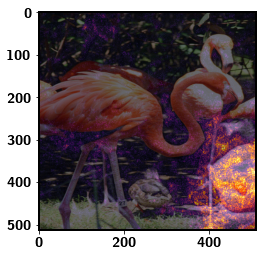

In [15]:
heatmap = fasterrcnn_ex1_map_dict['class_maps'][3]
plt.imshow(heatmap, cmap='inferno')
plt.imshow(fasterrcnn_ex1_image[1], alpha=0.4)
plt.show()

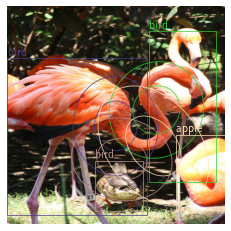

In [23]:
raw_image = cv2.imread(os.path.join(DATASET_PATH_USED, IMAGE_INDEX +'.jpg'))
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
image = resize_image(raw_image, (512, 512), 'None')
image_overlay = resize_image(raw_image, (512, 512), 'FasterRCNN')

fig = plt.figure(frameon=False, num=1, clear=True)
ax = fig.add_subplot()
ax.set_axis_off()

colors = get_matplotlib_colors(len(fasterrcnn_ex1_map_dict['class_maps']))
num_maps = len(fasterrcnn_ex1_map_dict['class_maps'])

for i in range(0, 4): 
    edge_color = colors[i]
    box = rescale_box(fasterrcnn_ex1_map_dict['class_maps_boxes'][i], raw_image.shape, 
                      fasterrcnn_ex1_map_dict['class_maps'][i].shape)
    plot_bbox(box, edge_color, ax)
    plot_explanation_ellipse(image, fasterrcnn_ex1_map_dict['class_maps'][i], edge_color, ax=ax, levels=2)
    plot_text(fasterrcnn_ex1_map_dict['labels'][i], box, edge_color, ax)
    
fig.savefig('contours.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
fig.clear()
plt.close(fig)
fig.clf()
